       AAPL      AMZN      GOOG      MSFT
0  0.000201 -0.004718  0.000089  0.001846
1 -0.034472 -0.030309 -0.018332 -0.012328
2 -0.005852  0.000147 -0.005153  0.002896
3 -0.015909 -0.004621 -0.011914 -0.014804
4  0.020189 -0.013348  0.014548  0.012666
Correlation heatmap saved to 'stock_correlation_heatmap.png'


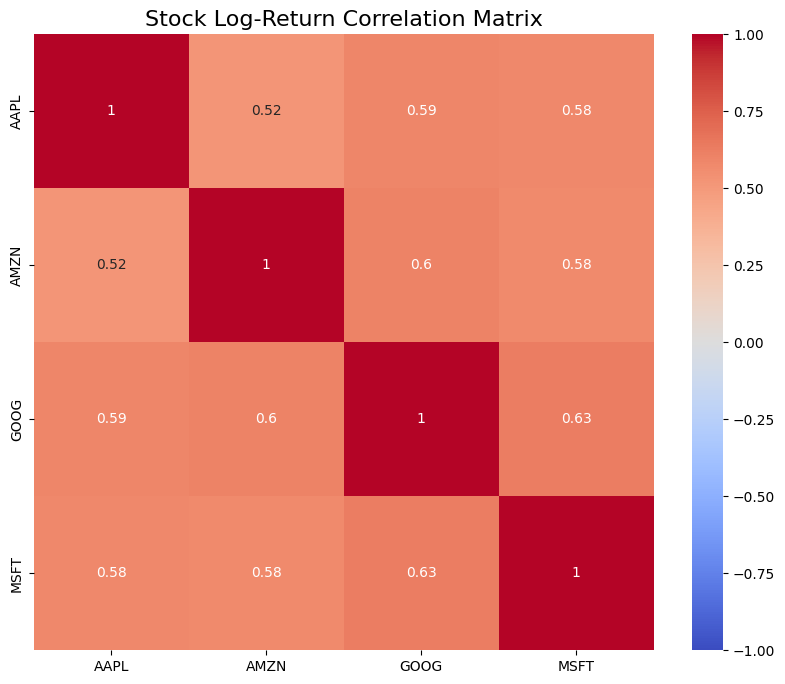

In [37]:
import pandas as pd
# load data from log-returns

df_log_returns = pd.read_csv('squashed_log_returns.csv')

print(df_log_returns.head())


# Calculate the correlation matrix from the original log-returns
corr_matrix = df_log_returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,     # Show the correlation values on the map
            cmap='coolwarm',# Use a blue-to-red color scheme
            vmin=-1, vmax=1) # Set the range from -1 to 1
plt.title('Stock Log-Return Correlation Matrix', fontsize=16)
plt.savefig('stock_correlation_heatmap.png')

print("Correlation heatmap saved to 'stock_correlation_heatmap.png'")


In [38]:
# split into train and test sets

TRAIN_RATIO = 0.8  # take the first 80% of df as requested

# Compute split index using the row order (first 80%)
n_rows = len(df)
split_index = int(n_rows * TRAIN_RATIO)

# First 80% (preserve original order); create df_test for remainder
df_train = df.iloc[:split_index].reset_index(drop=True)
df_test = df.iloc[split_index:].reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(12873, 3)
(3219, 3)


In [39]:
import numpy as np

#split into windows
WINDOW_SIZE = 4 #time windows of 4

df = pd.DataFrame(columns=['context','features','raw_label'])
    
for context, ticker in enumerate(df_log_returns.columns):
        
    stock_series = df_log_returns[ticker]
        
    # Slide a window across this one stock's time series
    # We stop (window_size - 1) from the end
    for i in range(len(stock_series) - WINDOW_SIZE + 1):
            
        # The full window (e.g., 4 log-returns)
        window = stock_series.iloc[i : i + WINDOW_SIZE]
            
        # Features are the first N-1 (e.g., 3)
        features = window[:-1].values
            
        # Label is the last one (e.g., the 4th)
        label = window.iloc[-1]

        df.loc[len(df)] = [context, features, label]

print(df.head())

   context                                           features  raw_label
0        0  [0.0002005581355387, -0.0344716210003059, -0.0...  -0.015909
1        0  [-0.0344716210003059, -0.0058524177522199, -0....   0.020189
2        0  [-0.0058524177522199, -0.0159089763398846, 0.0...  -0.003354
3        0  [-0.0159089763398846, 0.0201892151353554, -0.0...  -0.013201
4        0  [0.0201892151353554, -0.0033537334630132, -0.0...   0.015051


In [40]:
# Convert labels to bins
N_BINS = 2

context_min = df.groupby('context')['raw_label'].transform('min')
context_max = df.groupby('context')['raw_label'].transform('max')

midpoint = (context_min + context_max) / 2

df['label'] = (df['raw_label'] > midpoint).astype(int)

print(df.head(20))

    

    context                                           features  raw_label  \
0         0  [0.0002005581355387, -0.0344716210003059, -0.0...  -0.015909   
1         0  [-0.0344716210003059, -0.0058524177522199, -0....   0.020189   
2         0  [-0.0058524177522199, -0.0159089763398846, 0.0...  -0.003354   
3         0  [-0.0159089763398846, 0.0201892151353554, -0.0...  -0.013201   
4         0  [0.0201892151353554, -0.0033537334630132, -0.0...   0.015051   
5         0  [-0.0033537334630132, -0.0132006247246812, 0.0...  -0.024325   
6         0  [-0.0132006247246812, 0.0150505024540143, -0.0...  -0.024843   
7         0  [0.0150505024540143, -0.0243246601000814, -0.0...   0.003387   
8         0  [-0.0243246601000814, -0.0248425473061451, 0.0...   0.001267   
9         0  [-0.0248425473061451, 0.0033870642270147, 0.00...  -0.015673   
10        0  [0.0033870642270147, 0.0012671037887501, -0.01...  -0.048849   
11        0  [0.0012671037887501, -0.0156734366961577, -0.0...  -0.010973   

In [41]:
# split into train and test sets

TRAIN_RATIO = 0.8  # take the first 80% of df as requested

# Compute split index using the row order (first 80%)
n_rows = len(df)
split_index = int(n_rows * TRAIN_RATIO)

# First 80% (preserve original order); create df_test for remainder
df_train = df.iloc[:split_index].reset_index(drop=True)
df_test = df.iloc[split_index:].reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(12873, 4)
(3219, 4)


In [42]:
import pennylane as qml
#Build the circuit

n_stocks = df_log_returns.shape[1]

# 0-1: context qubits
# 2-4: input qubits
# 5: output qubit
N_CONTEXT_WIRES = int(np.log2(n_stocks))  # Number of qubits needed to represent stocks
N_INPUT_WIRES = df_train['features'].loc[0].shape[0]  # Should be 3
N_OUTPUT_WIRES = int(np.log2(N_BINS))
N_TOTAL_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES

N_LAYERS = 2

LEARNING_RATE = 0.01 # We will adjust this in the training cell
N_EPOCHS = 10

CONTEXT_WIRES = list(range(N_CONTEXT_WIRES))
INPUT_WIRES = list(range(N_CONTEXT_WIRES, N_CONTEXT_WIRES + N_INPUT_WIRES))
OUTPUT_WIRES = list(range(N_CONTEXT_WIRES + N_INPUT_WIRES, N_TOTAL_WIRES))
COMP_WIRES = list(range(N_CONTEXT_WIRES, N_CONTEXT_WIRES + N_OUTPUT_WIRES + N_INPUT_WIRES))

dev = qml.device("default.qubit", wires=6)

#input layer
def U_in(features):
    """The data encoding block (feature map)."""
    # We use arctan to squash features, as discussed
    # Note: As mentioned previously, you should apply np.arctan here
    squashed_features = np.arctan(features)
    for i, wire in enumerate(INPUT_WIRES):
        qml.RY(squashed_features[i], wires=wire)

# layer for both either the shared or specify ansatz (input is just trainable parameters)
def U_ss(params):
    """A single (L=1) ansatz layer (Rotations + CNOTs)."""
    # 1. Trainable Rotations
    for i, wire in enumerate(COMP_WIRES):
        qml.RY(params[i], wires=wire)
    
    # 2. Entangling "Ring"
    for i in range(len(COMP_WIRES)):
        qml.CNOT(wires=[COMP_WIRES[i], COMP_WIRES[(i + 1) % len(COMP_WIRES)]])

# --- THIS IS THE KEY CHANGE ---
# 1. diff_method is now 'spsa'
# 2. 'h=0.01' is the SPSA perturbation size hyperparameter
@qml.qnode(dev, interface='torch', diff_method='spsa')
def qmtl_circuit(params, features, context):
    # Encode input features into qubits 2, 3, 4
    U_in(features)

    #Implement shared variational layers
    for l in range(N_LAYERS):
        U_ss(params['shared'][l])

    #Implement specify layers
    for l in range(N_LAYERS):
        U_ss(params['spec'][context][l])

    # Measure output qubit (wire 5)
    return qml.probs(wires=N_CONTEXT_WIRES + N_INPUT_WIRES)

In [ ]:
#Test the circuit with dummy parameters
for stock, stock_features in enumerate(train_features): 

    for features in stock_features[:1]: # only first element for testing
        
        params = dict()
        params['shared'] = [[0.1, 0.2, 0.3, 0.4],[0.5, 0.6, 0.7, 0.8]]
        params['spec'] = [
            [[-0.1, -0.1, -0.1, -0.1], [-0.2, -0.2, -0.2, -0.2]],
            [[-0.3, -0.3, -0.3, -0.3], [-0.4, -0.4, -0.4, -0.4]],
            [[-0.5, -0.5, -0.5, -0.5], [-0.6, -0.6, -0.6, -0.6]],
            [[-0.7, -0.7, -0.7, -0.7], [-0.8, -0.8, -0.8, -0.8]]]
        # Execute the circuit
        result = qmtl_circuit(params, features, stock)
        print("Features:", features, "Output expectation:", result)

        drawing = qml.draw(qmtl_circuit)(params, features, stock)
        print(drawing)

IndexError: string index out of range

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

LEARNING_RATE = 0.001
N_EPOCHS = 50

def init_params():
    """
    Initialize the trainable parameters using torch.nn.Parameter
    """
    n_params_per_layer = len(COMP_WIRES) # 3 input + 1 output = 4
    
    # --- Shared Parameters ---
    # We need L=2 layers of 4 params each
    shared_params = torch.randn(N_LAYERS, n_params_per_layer, requires_grad=True)
    
    # --- Specify Parameters ---
    # We need K=4 sets of (L=2 layers * 4 params each)
    n_stocks = 2**N_CONTEXT_WIRES
    spec_params = torch.randn(n_stocks, N_LAYERS, n_params_per_layer, requires_grad=True)
    
    # We use torch.nn.ParameterDict to keep them organized
    return nn.ParameterDict({
        "shared": nn.Parameter(shared_params),
        "spec": nn.Parameter(spec_params)
    })

#Train the circuit
params = init_params()

optimizer = torch.optim.Adam(params.values(), lr=LEARNING_RATE)

#KL-Divergence used
loss_fn = nn.KLDivLoss()

print("\n--- Starting Training ---")

# List to store loss values for plotting
epoch_losses = []
    
# Define the subset for training
train_subset = df_train     

# --- Run Epochs ---
for epoch in range(N_EPOCHS):
    total_loss = 0
    
    # We loop through the training set one sample at a time
    # (This is Stochastic Gradient Descent, Batch Size = 1)
    # TODO: Increase batch size for more efficiency
    for index, row in train_subset.iterrows(): 
        
        # Create the one-hot true label vector [P(0), P(1)]
        y_true_onehot = torch.tensor([0.0, 0.0])
        y_true_onehot[row['label']] = 1.0
        
        # 2. Run circuit, y_pred = [P(0), P(1)]
        y_pred = qmtl_circuit(params, row['features'], row['context'])
        
        # Calculate Loss
        # **CRITICAL**: KLDivLoss expects log-probabilities
        loss = loss_fn(torch.log(y_pred), y_true_onehot)
        
        # Calculate Gradients
        # PyTorch and PennyLane work together to run the parameter-shift rule for ALL parameters.
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Clear gradients
        optimizer.zero_grad()
        
        total_loss += loss.item()
    
    # Corrected average loss calculation
    avg_loss = total_loss / len(train_subset)
    epoch_losses.append(avg_loss) # Store for plotting
    print(f"Epoch {epoch+1}/{N_EPOCHS} - Avg. Loss: {avg_loss:.4f}")

print("--- Training Complete ---")
print("Final Parameters (Shared):")
print(params['shared'])
print("Final Parameters (Specify):")
print(params['spec'])


--- Starting Training ---


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:3355: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/50 - Avg. Loss: 0.1063
Epoch 2/50 - Avg. Loss: 0.0954
Epoch 3/50 - Avg. Loss: 0.0956
Epoch 4/50 - Avg. Loss: 0.0951
Epoch 5/50 - Avg. Loss: 0.0951
Epoch 6/50 - Avg. Loss: 0.0955
Epoch 7/50 - Avg. Loss: 0.0950
Epoch 8/50 - Avg. Loss: 0.0954
Epoch 9/50 - Avg. Loss: 0.0948
Epoch 10/50 - Avg. Loss: 0.0953
Epoch 11/50 - Avg. Loss: 0.0949
Epoch 12/50 - Avg. Loss: 0.0957
Epoch 13/50 - Avg. Loss: 0.0957
Epoch 14/50 - Avg. Loss: 0.0950
Epoch 15/50 - Avg. Loss: 0.0959
Epoch 16/50 - Avg. Loss: 0.0956
Epoch 17/50 - Avg. Loss: 0.0954
Epoch 18/50 - Avg. Loss: 0.0949
Epoch 19/50 - Avg. Loss: 0.0949
Epoch 20/50 - Avg. Loss: 0.0950
Epoch 21/50 - Avg. Loss: 0.0949
Epoch 22/50 - Avg. Loss: 0.0967
Epoch 23/50 - Avg. Loss: 0.0946
Epoch 24/50 - Avg. Loss: 0.0963
Epoch 25/50 - Avg. Loss: 0.0952
Epoch 26/50 - Avg. Loss: 0.0951



--- Starting Testing ---
Test Subset Accuracy: 82.89%
Results DataFrame created.


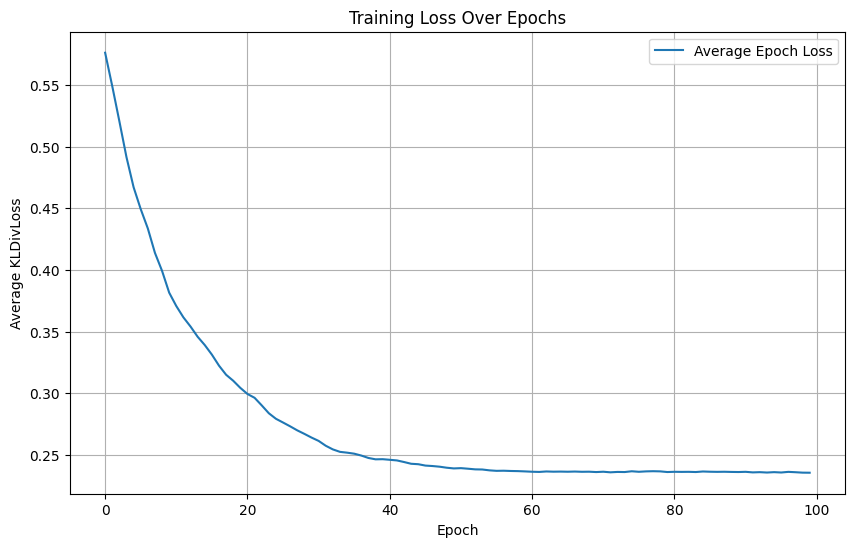

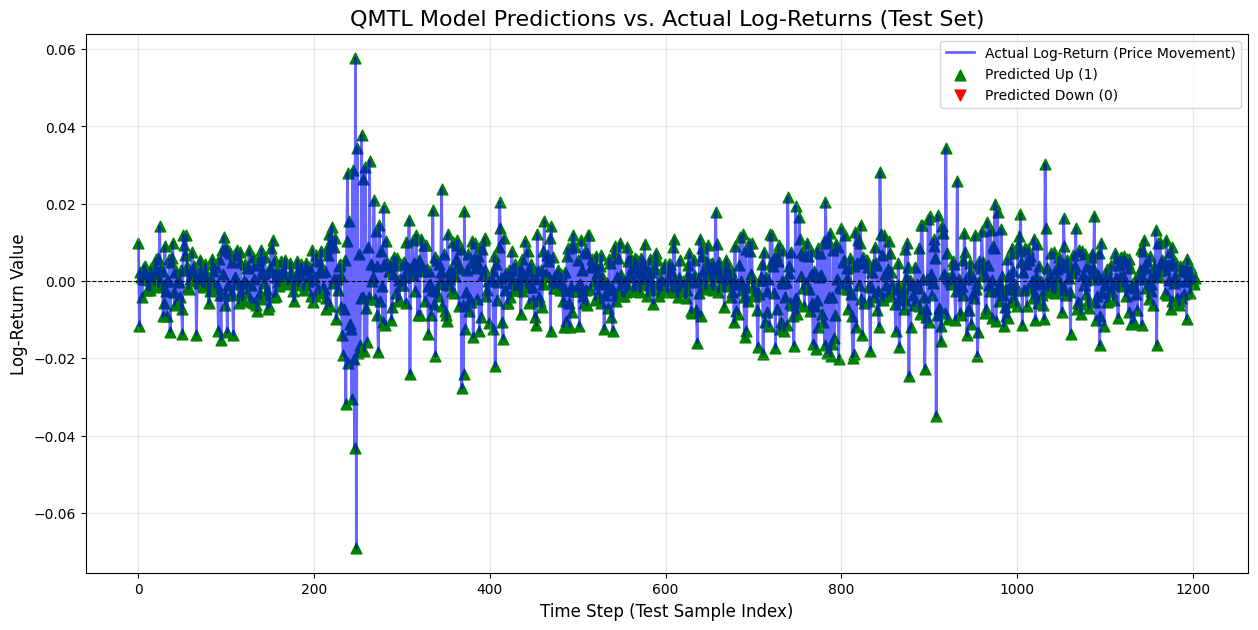

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Average Epoch Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average KLDivLoss')
plt.legend()
plt.grid(True)



print("\n--- Starting Testing ---")

results_list = []

with torch.no_grad():
    
    test_subset = df_test
    
    for index, row in test_subset.iterrows():
        features = row['features']
        context = row['context']
        true_label = row['label']
        raw_label = row['raw_label'] 
        
        y_pred_probs = qmtl_circuit(params, features, context)
        predicted_label = torch.argmax(y_pred_probs).item()
        
        results_list.append({
            'index': index,
            'raw_label': raw_label,
            'true_label': true_label,
            'predicted_label': predicted_label
        })

df_results = pd.DataFrame(results_list).set_index('index')

accuracy = (df_results['true_label'] == df_results['predicted_label']).mean()
print(f"Test Subset Accuracy: {accuracy * 100:.2f}%")
print("Results DataFrame created.")


plt.figure(figsize=(15, 7))

plt.plot(df_results.index, df_results['raw_label'], 
         label='Actual Log-Return (Price Movement)', 
         color='blue', 
         alpha=0.6, 
         linewidth=2)


plt.axhline(0, color='black', linestyle='--', linewidth=0.8)


preds_up = df_results[df_results['predicted_label'] == 1]
preds_down = df_results[df_results['predicted_label'] == 0]

plt.scatter(preds_up.index, preds_up['raw_label'], 
            label='Predicted Up (1)', 
            color='green', 
            marker='^', 
            s=60)

plt.scatter(preds_down.index, preds_down['raw_label'], 
            label='Predicted Down (0)', 
            color='red', 
            marker='v', 
            s=60)

plt.title('QMTL Model Predictions vs. Actual Log-Returns (Test Set)', fontsize=16)
plt.xlabel('Time Step (Test Sample Index)', fontsize=12)
plt.ylabel('Log-Return Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)



Text(0.5, 36.72222222222221, 'Predicted Label')

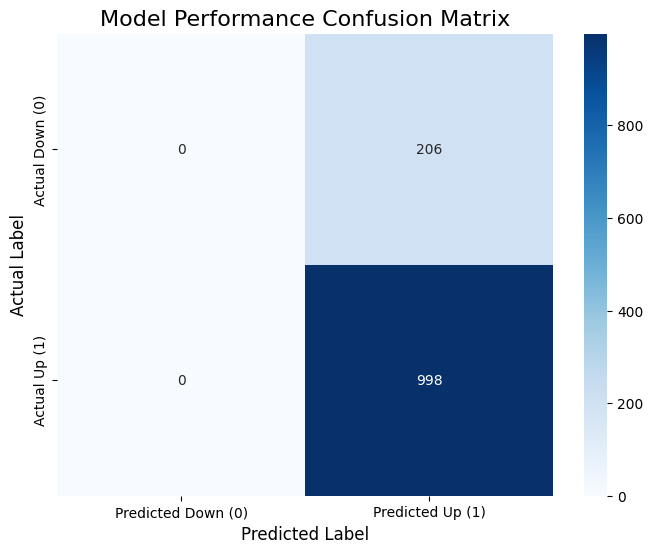

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


true_labels = df_results['true_label']
predicted_labels = df_results['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True,     
            fmt='d',        
            cmap='Blues',   
            xticklabels=['Predicted Down (0)', 'Predicted Up (1)'],
            yticklabels=['Actual Down (0)', 'Actual Up (1)'])
plt.title('Model Performance Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)



In [29]:
# 5. Answer your request: Show label distribution
print("\n--- Label Distribution in Training Data ---")
print(df_train['label'].value_counts(normalize=True))

print("\n--- Label Distribution in Test Data ---")
print(df_test['label'].value_counts(normalize=True))


--- Label Distribution in Training Data ---
label
1    0.783846
0    0.216154
Name: proportion, dtype: float64

--- Label Distribution in Test Data ---
label
1    0.828904
0    0.171096
Name: proportion, dtype: float64
